In [1]:
import numpy as np
import pandas as pd
import pysam
import random

from convert import convert_hap_samples_to_dataframe
import os
import math
from copy import deepcopy
import numba
import os
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import subprocess
import json

import warnings
warnings.filterwarnings('ignore')

K=10

def get_file(data_path):
    '''从文件夹中，得到各文件的路径'''
    for filename in os.listdir(data_path):
        if filename.endswith('.gz'):
            hap_file = os.path.join(data_path,filename)
        if filename.endswith('.sample'):
            samples_file = os.path.join(data_path,filename)
        if filename.endswith('.vcf'):
            vcf_file = os.path.join(data_path,filename)
        if filename.endswith('.ped'):
            ped_file = os.path.join(data_path,filename)
    assert (hap_file and samples_file and vcf_file and ped_file),'missing data file'
    return  hap_file,samples_file,vcf_file,ped_file

def calcul_XY(df_select):
    '''遍历选择的位点计算X,Y和c, 返回logX,logY and c'''
    log_mu = -8 # 默认突变概率为1e-8
    log2 = np.log10(2)

    n = df_select.shape[0]
    log_x = 0
    log_y = 0
    c = []
    
    for i in range(n):
        father = df_select['faGT'][i]
        mother = df_select['moGT'][i]
        child = df_select['chGT'][i]
        if child == (0,0):
            if mother == (0,1) or mother == (1,0):
                log_y = log_y - log2
                c.append(0)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - 2*log2
                elif father == (0,0):
                    log_x = log_x - log2
                else:
                    log_x = log_x + log_mu - log2

            elif mother == (0,0):
                c.append(0)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - log2
                elif father == (0,0):
                    pass
                else:
                    log_x = log_x + log_mu

            else:
                log_y = log_y + log_mu
                c.append(0)
                if father == (0,1) or father == (1,0):
                    log_x = log_x + log_mu -log2
                elif father == (0,0):
                    log_x = log_x + log_mu
                else:
                    log_x = log_x + 2*log_mu

        elif child == (0,1) or child == (1,0):
            if mother == (0,1) or mother == (1,0):
                c.append(0)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - log2
                elif father == (0,0):
                    log_x = log_x - log2
                else:
                    log_x = log_x - log2
            #    assert 1==0,'mother and child are both heteGT'

            elif mother == (0,0):
                c.append(1)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - log2
                elif father == (0,0):
                    log_x = log_x + log_mu
                else:
                    pass

            else:
                c.append(0)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - log2
                elif father == (0,0):
                    pass
                else:
                    log_x = log_x + log_mu

        else:
            if mother == (0,1) or mother == (1,0):
                log_y = log_y - log2
                c.append(1)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - 2*log2
                elif father == (0,0):
                    log_x = log_x + log_mu - log2
                else:
                    log_x = log_x -log2

            elif mother == (0,0):
                log_y = log_y + log_mu
                c.append(1)
                if father == (0,1) or father == (1,0):
                    log_x = log_x + log_mu - log2
                elif father == (0,0):
                    log_x = log_x + 2* log_mu
                else:
                    log_x = log_x + log_mu

            else:
                c.append(1)
                if father == (0,1) or father == (1,0):
                    log_x = log_x - log2
                elif father == (0,0):
                    log_x = log_x + log_mu
                else:
                    pass
    c = np.array(c)
    # print('X,Y,len_c:',log_x,log_y,c.shape)
    return log_x,log_y,c


def calcul_pi_ind(df_select,log_x,log_y,c):
    '''计算独立情况的亲权系数'''
    f0 = df_select['f0'].values
    pr_ind = (np.log10(np.where(c==0,f0,1-f0))).sum() # type: ignore
    return log_x - log_y - pr_ind

@numba.jit(nopython=True)
def freq2(x,y):
    '''返回bool列表,True表示x,y对应位置同时为0'''
    return (x==0)&(y==0)

def calcul_fij(df_data,fi,locus_list,n):
    num_row = df_data.shape[0]
    fij = np.zeros((n,n))
    for i in range(n):  # 因为fij对称，只遍历上三角矩阵
        col1 = df_data[locus_list[i]].to_numpy().astype(int)   # 这里类型的变换，是为了使用numba加速
        for j in range(i+1,n):
            col2 = df_data[locus_list[j]].to_numpy().astype(int)
            fij[i,j] = freq2(col1,col2).sum()/num_row  # 统计两列数据同时为０的概率
            fij[j,i] = fij[i,j]
    for i in range(n):
        fij[i,i] = fi[i]
    return fij

def freq_pc(df_data,locus_list,fi,n,pc):
    fij = calcul_fij(df_data,fi,locus_list,n)
    return (1-pc)*fi + pc/2,(1-pc)*fij + pc/4

def cMat(fi,fij,n,alpha):
    cmat = fij - fi*(fi.reshape(n,1))
    print('\t c的最小特征值',np.min(np.linalg.eigvals(cmat)))
    cmat = np.where(cmat>alpha,cmat,0)
    return cmat

def inv_eig(cmat):
    D,V = np.linalg.eig(cmat)
    lambda_inv= np.diag(list(map(lambda x: x.real/(0.001+x.real**2), D)))
    inv_C2 = np.dot(np.dot(V, lambda_inv), V.T).real
    return inv_C2

def invc_glassoR(cmat,rho1,rho2):
    c_path = '/home/anran/paternity/version4/cmat.txt'
    invc_path = '/home/anran/paternity/version4/invc.txt'
    invg_path = "/home/anran/paternity/version4/invc_glasso.csv"
    np.savetxt(c_path,cmat)
    np.savetxt(invc_path,inv_eig(cmat))
    r_path = f"/home/anran/paternity/version4/invc.R"
    r_command = ['Rscript',r_path]
    r_command.extend(map(str,[c_path, invc_path, invg_path,rho1, rho2]))
    subprocess.run(r_command,check=True)
    invc = pd.read_csv(invg_path,sep=' ').values
    if(os.path.isfile(c_path)):  # 删除保存的数据文件
        os.remove(c_path)
        os.remove(invc_path)
        os.remove(invg_path)
    return invc


def calcul_e(invc,fi,n):
    res = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a = 2*fi[i]*fi[j]
            delta = 1-4*a*invc[i, j]
            if delta<0 or fi[i]==0 or fi[j]==0:
                res[i,j] = -invc[i,j]
            elif delta==0:
                res[i,j] =  -1/(2*a)
            else:
                s1 = (-1+math.sqrt(delta))/(2*a)
                s2 = (-1+math.sqrt(delta))/(2*a)
                if abs(s1-invc[i,j])>abs(s2-invc[i,j]):  # 当有2实根，选择距-invc较近的根
                    res[i,j] = s2
                else:
                    res[i,j] = s1
    print('\t emat:',res.min(),res.max())
    return res


def margin(fi,emat,n):
    e = deepcopy(emat)
    for i in range(n):  # h计算时，对j!=i的eij项操作
        e[i,i] = 0
    h = np.arctanh(fi) + (e**2 * fi.reshape(n,1) * (1-fi**2)).sum(axis=1) - (e*fi).sum(axis=1)
    print('\t h:',h.min(),h.max())
    return h


def get_b(k):
    '''根据k生成b, 维度为(2^k,k), 一行是一个样本'''
    num_rows = 2**k  # 矩阵b的行数
    b = np.zeros((num_rows, k), dtype=int)
    for i in range(num_rows):
        binary_representation = format(i, '0' + str(k) + 'b')  # 将整数i转换为k位的二进制字符串
        for j in range(k):
            b[i, j] = int(binary_representation[j])
    return b

def select_emat(seq,j,emat,k):
    '''对于第j个位点, 只考虑它及其前面的k-1个位点
    取出emat中的子方阵[j-k+1.j-k+1]->[j,j]
    根据seq计算对应的系数(1 or -1)'''
    s = np.tile(seq,(k,1))
    mask = np.logical_not(s ^ s.T)  # 00/11->1,01/10->0
    mask = np.where(mask==0,-1,mask)  
    return np.triu(emat[j-k+1:j+1,j-k+1:j+1]*mask,1)

def get_addition(j,k,b,e,h):
    '''返回E向量, 维度(2**k,)'''
    coef = np.zeros(2**k)
    for i in range(2**k):
        seq = b[i,:]
        mask = np.where(np.logical_not(seq[-1]^seq[:-1]),1,-1)
        coef[i] = (e[j,j-k+1:j] * mask).sum() + h[j]*(-1)**seq[-1]
    return coef

def calcul_Z(e,h,k,n):
    z = np.zeros((2**k,n-k+1))
    b = get_b(k)

    for i in range(2**k):  # 计算ｚ的第一列数据z[0]
        seq = b[i,:]
        z[i,0] = (h[:k]*np.where(seq==0,1,-1)).sum()+select_emat(seq,k-1,e,k).sum()
    
    for l in range(1,n-k+1): # 循环计算z[1]到z[n-k], l指向z的index, 对应e/h的index为 l+(k-1)
        coef = get_addition(l+k-1,k,b,e,h)
        for i in range(2**k):
            seq = b[i,:]
            l0 = (i-seq[-1]) // 2  # 二进制数右移移位，最高位为0
            l1 = (l0 + 2**(k-1)) # 二进制数右移移位，最高位为１
            z0 = min(z[l0,l-1],z[l1,l-1])
            z1 = max(z[l0,l-1],z[l1,l-1])
            if z1-z0>200:
                z[i,l] = coef[i] + z1
            else: 
                z[i,l] = coef[i] + z0 + np.log(np.exp(1)+np.exp(z1-z0))
    z_min = z[:,-1].min()
    log10_z = np.log10(np.exp(z[:,-1]-z_min).sum()) + np.log10(np.exp(1))*z_min
    return log10_z

def calcul_num(c, e, h, n, k):
    '''输入e维度N*N
    返回10的指数部分'''
    nums = np.zeros(n-k+1)
    sum_h = (h*np.where(c==0,1,-1)).sum()

    nums[0] = select_emat(c[:k],k-1,e,k).sum()

    for j in range(k,n):
        l = j-k+1  # nums中的index
        mask = np.where(np.logical_not(c[j]^c[l:j]),1,-1)  # 使用c_j与其前k-1个位点计算mask
        coef = (e[j,l:j] * mask).sum()
        nums[l] = coef + nums[l-1]
    return (nums[-1]+sum_h)*np.log10(np.exp(1))

def get_fi(df_data,start,end):
    f0 = {}
    totle = df_data.shape[0]
    columns = df_data.columns.to_list()
    print('linkage area: ',columns[start],' to ', columns[end-1])
    for i in range(start,end-1):
        locus = columns[i]
        freq = (df_data[locus]==0).sum()/totle
        f0[locus] = freq
    fi = pd.Series(f0)
    return fi

def get_fi_ind(df_data,start,end,n):
    f0={}
    totle = df_data.shape[0]
    num_col = df_data.shape[1]
    # index_available = np.append(np.arange(start),np.arange(end+1,num_col))
    # print(index_available.shape)
    index = np.random.choice(np.append(np.arange(start),np.arange(end+1,num_col)),size=n,replace=False)
    columns = df_data.columns.to_list()
    for i in index:
        locus = columns[i]
        freq = (df_data[locus]==0).sum()/totle
        f0[locus] = freq
    fi = pd.Series(f0)
    return fi

def get_data(start,fi_serie,df_person, father, mother, child):
    '''根据locus_list抽取人的数据'''
    df = pd.DataFrame(columns=['locus','moGT','faGT', 'chGT','f0'])
    for locus in range(start,start+fi_serie.shape[0]):
        mo = df_person.iloc[mother,locus]
        fa = df_person.iloc[father,locus]
        ch = df_person.iloc[child,locus]
        f0 = fi_serie[locus-start]
        df.loc[len(df.index)] = [locus,mo,fa,ch,f0] # type: ignore
    df.set_index('locus',drop=True,inplace=True)
    return df

In [2]:
# rho1 = 0.5
# rho2 = 0
# pc = 0.001
alpha = 0.001
data_path = "/home/anran/paternity/family-data/sim_seg1" 
print(data_path)
# 数据集信息
hap_file,samples_file,_,_ = get_file(data_path)
df_data_init = convert_hap_samples_to_dataframe(hap_file,samples_file)
# df_data.drop(['ID','REF','ALT'],axis=0,inplace=True)
df_data = pd.read_csv('/home/anran/paternity/family-data/sim_data/df_data.csv')
df_data.drop(['personID'], axis=1,inplace=True)
df_data.columns = df_data_init.columns

/home/anran/paternity/family-data/sim_seg1


In [3]:
with open('/home/anran/paternity/family-data/sim_data/df_data.json') as f:
    data = json.load(f)
start = data['linkage_keys'][0]
end = data['linkage_keys'][-1]

with open('/home/anran/paternity/family-data/sim_data/family.json') as f:
    family = json.load(f)
family2 = deepcopy(family)
person = []
for key in family2.keys():
    if key != 'linkage_keys':
        person.append([int(key)]+family[key])
persons = pd.DataFrame(person,columns = ['child','father','mother'])
print(persons)
print(start,end)

   child  father  mother
0     10       8       5
1     11       6       7
2     12       9       1
3     13       4       3
4     14       0       2
35649 36650


In [4]:
fi_serie = get_fi(df_data,start,end)
N = fi_serie.shape[0]
print(N)
fi_serie[:3]

linkage area:  ('chr6', '21361679')  to  ('chr6', '21398959')
1000


chr6  21361679    1.0
      21361685    1.0
      21361757    1.0
dtype: float64

In [5]:
pc = 0.1
locus_list = fi_serie.index.to_list()
fi =  fi_serie.values
# fij = calcul_fij(df_data,fi,locus_list,N)
fi,fij = freq_pc(df_data,locus_list,fi,N,pc)
print('fi and same fi:',fi[0],(fi==fi[0]).sum()==N)
print('fij and same fij:',fij[0,0],(fij==fij[0,0]).sum()==N**2)

fi and same fi: 0.9500000000000001 True
fij and same fij: 0.925 True


In [6]:
rho1 = 0.5
rho2 = 0.001
cmat = cMat(fi,fij,N,alpha)  
invc = invc_glassoR(cmat,rho1,rho2)
diag = ((invc-np.diag(np.diagonal(invc)))==0).all()  # 判断逆矩阵是否为对角矩阵
print('matrix inverse est diag:',diag)

	 c的最小特征值 (-1.5870548222926701e-15-5.994956165764367e-16j)
matrix inverse est diag: False


In [7]:
emat = calcul_e(invc,fi,N) 
# print('e(e[0,0],num_e00,num0):',emat[0,0],(emat==emat[0,0]).sum(),(emat==0).sum())
h = margin(fi,emat,N)
log_z = calcul_Z(emat,h,K,N)
print(log_z)

	 emat: -1.95277133782566 0.054562473310483736
	 h: 1.0101535826333001 1.367753990430569
658.4760302924959


In [9]:
print('e')
print(emat[:2,:11])
print('h')
print(h[:5])
print(h[-5:])

e
[[-1.936072    0.05456241  0.05456242  0.05456241  0.05456241  0.0545624
   0.05456239  0.05456238  0.05456244  0.05456245  0.        ]
 [ 0.0545624  -1.93792748  0.05300864  0.05300863  0.05300863  0.05300862
   0.05300861  0.05300859  0.05300866  0.05300867  0.05456245]]
h
[1.36775394 1.32788025 1.28805808 1.24828068 1.20854115]
[1.20854132 1.24828081 1.28805817 1.32788033 1.36775399]


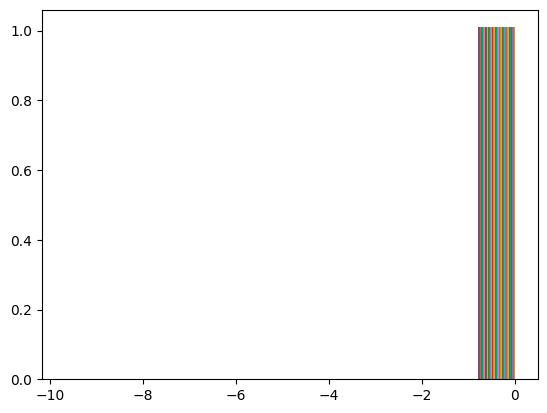

In [25]:
import matplotlib.pyplot as plt
plt.hist(emat,density=True)
plt.show();

In [34]:
res = pd.DataFrame(columns=['father','mother','child','c','log_x','log_y','log_fi','num','z','pi_ind','pi_nind'])
for fa in [(0,0),(0,1),(1,1)]:
    for ch in [(0,0),(0,1),(1,1)]:
        for mo in [(0,0),(0,1),(1,1)]:
            no_father1 = pd.DataFrame(columns=['moGT','faGT','chGT','f0'])
            no_father1.faGT = [fa]*N
            no_father1.moGT = [mo]*N
            no_father1.chGT = [ch]*N
            no_father1.f0 = fi
            # display(no_father1.head())
            log_x,log_y,c = calcul_XY(no_father1)
            # print('log_x,log_y',log_x,log_y)
            sum_c = (c == 1).sum()
            prod_fi = (np.log10(np.where(c==0,fi,1-fi))).sum()
            # print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
            log_pi_ind = calcul_pi_ind(no_father1,log_x,log_y,c)
            log_num = calcul_num(c,emat,h,N,K)
           
            log_pi_nind = log_x-log_y-log_num+log_z
            
            res = res._append({'father':fa,
                            'c':sum_c,
                            'mother':mo,
                            'child':ch,
                            'log_x':log_x,
                            'log_y':log_y,
                            'log_fi':prod_fi,
                            'num':log_num,
                            'z':log_z,
                            'pi_ind':log_pi_ind,
                            'pi_nind':log_pi_nind}, ignore_index=True) # type: ignore
res.to_csv('/home/anran/paternity/version4/result_debug/final_result4.csv')


In [19]:
person_data = pd.read_csv('/home/anran/paternity/family-data/sim_data/person.csv')
df_select = get_data(start,fi_serie,person_data,persons.father[0],persons.mother[0],persons.child[0])
df_select.set_index(np.arange(df_select.shape[0]),drop=True,inplace=True)
df_select.head()

,moGT,faGT,chGT,f0
0,"('0', '0')","('0', '0')","('0', '0')",1.0
1,"('0', '0')","('0', '0')","('0', '0')",1.0
2,"('0', '0')","('0', '0')","('0', '0')",1.0
3,"('0', '0')","('0', '0')","('0', '0')",1.0
4,"('0', '0')","('0', '0')","('0', '0')",1.0


In [25]:
df_select['faGT'][0] == "('0', '0')"

True

In [32]:
locus_list = fi_serie.index.to_list()
fi =  fi_serie.values
fi,fij = freq_pc(df_data,locus_list,fi,N,pc)
cmat = cMat(fi,fij,N,alpha)  
invc = invc_glassoR(cmat,rho1,rho2)
diag = ((invc-np.diag(np.diagonal(invc)))==0).all()
print('\t 对角阵？',diag)
emat = calcul_e(invc,fi,N) 
h = margin(fi,emat,N)
log_z = calcul_Z(emat,h,K,N)

	 c的最小特征值 (-1.0110482766322549e-14+0j)
	 对角阵？ True
	 emat: -2.0 0.0
	 h: 1.3889968904977033 4.146899804423353


In [49]:
pc = 0.1
alpha = 0.001
rho1 = 0.5
rho2 = 0.01
fi =  fi_serie.values
fi,fij = freq_pc(df_data,locus_list,fi,N,pc)
cmat = cMat(fi,fij,N,alpha)  
invc = invc_glassoR(cmat,rho1,rho2)
diag = ((invc-np.diag(np.diagonal(invc)))==0).all()
print('\t 对角阵？',diag)
emat = calcul_e(invc,fi,N) 
h = margin(fi,emat,N)

	 c的最小特征值 (-4.4550954362510815e-15+0j)
	 对角阵？ False
	 emat: -1.92913669611062 0.1786534208258854
	 h: 0.6582663627460281 1.5235440808106624


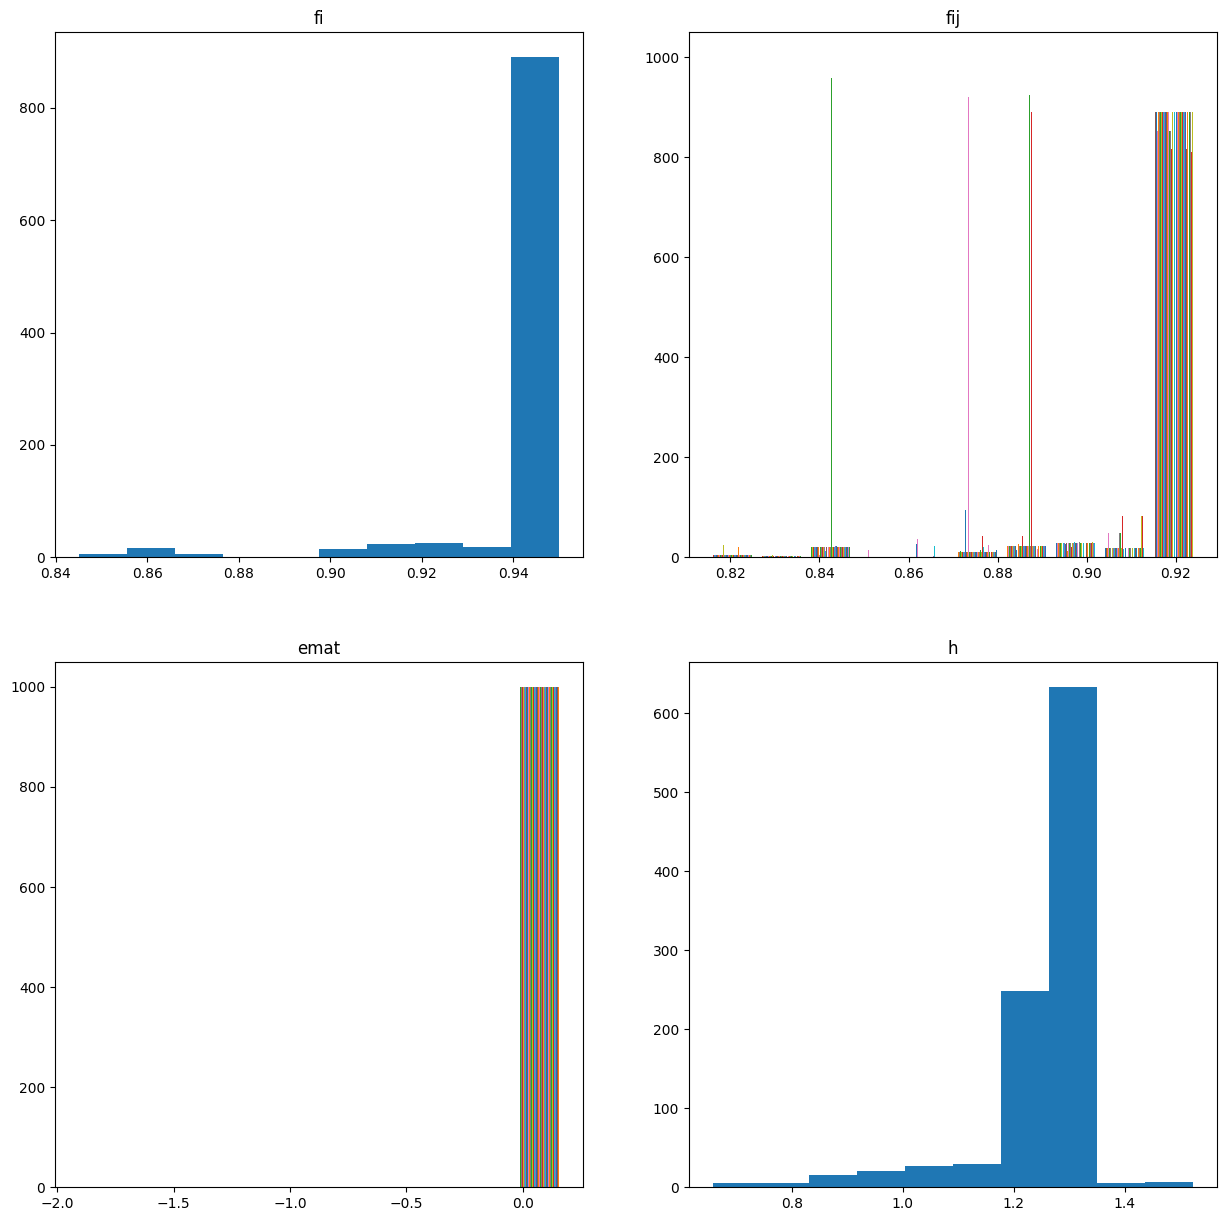

In [50]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1) 
plt.hist(fi) 
plt.title('fi')

plt.subplot(2, 2, 2)  
plt.hist(fij,bins=10) 
plt.title('fij')

plt.subplot(2, 2, 3)  
plt.hist(emat,bins=10) 
plt.title('emat')

plt.subplot(2, 2, 4)  
plt.hist(h) 
plt.title('h')

plt.show();

In [11]:
print('分母',log_z)
for i in range(3):
    for j in range(1):
        print('--------------------------------',i,j)
        df_select = get_data(start,fi_serie,person_data,persons.father[i],persons.mother[j],persons.child[j])
        df_select.set_index(np.arange(df_select.shape[0]),drop=True,inplace=True)
        display(df_select.iloc[:5,:3])
        log_x,log_y,c = calcul_XY(df_select)
        print('log_x,log_y',log_x,log_y)
        print('c=1的位置',np.where(c == 1))
        f0 = df_select['f0'].values
        print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
        log_pi_ind = calcul_pi_ind(df_select,log_x,log_y,c)
        log_num = calcul_num(c,emat,h,N,K)
        print('分子:',log_num)
        log_pi_nind = log_x-log_y-log_num+log_z
        print('pi_ind:',log_pi_ind)
        print('pi_nind:',log_pi_nind)

分母 1619.6994859916726
-------------------------------- 0 0


,moGT,faGT,chGT
0,"(0, 0)","(0, 0)","(0, 0)"
1,"(0, 0)","(0, 0)","(0, 0)"
2,"(0, 0)","(0, 0)","(0, 0)"
3,"(0, 0)","(0, 0)","(0, 0)"
4,"(0, 0)","(0, 0)","(0, 0)"


log_x,log_y 0 0
c=1的位置 (array([], dtype=int64),)
fi连乘: -2.8203480300611896
分子: 1615.734923676581
pi_ind: 2.8203480300611896
pi_nind: 3.964562315091598
-------------------------------- 1 0


,moGT,faGT,chGT
0,"(0, 0)","(0, 0)","(0, 0)"
1,"(0, 0)","(0, 0)","(0, 0)"
2,"(0, 0)","(0, 0)","(0, 0)"
3,"(0, 0)","(0, 0)","(0, 0)"
4,"(0, 0)","(0, 0)","(0, 0)"


log_x,log_y 0 0
c=1的位置 (array([], dtype=int64),)
fi连乘: -2.8203480300611896
分子: 1615.734923676581
pi_ind: 2.8203480300611896
pi_nind: 3.964562315091598
-------------------------------- 2 0


,moGT,faGT,chGT
0,"(0, 0)","(0, 0)","(0, 0)"
1,"(0, 0)","(0, 0)","(0, 0)"
2,"(0, 0)","(0, 0)","(0, 0)"
3,"(0, 0)","(0, 0)","(0, 0)"
4,"(0, 0)","(0, 0)","(0, 0)"


log_x,log_y 0 0
c=1的位置 (array([], dtype=int64),)
fi连乘: -2.8203480300611896
分子: 1615.734923676581
pi_ind: 2.8203480300611896
pi_nind: 3.964562315091598


In [137]:
df_select.shape

(1000, 4)

- 11+00=00

In [139]:
no_father1 = pd.DataFrame(columns=['moGT','faGT','chGT','f0'])
no_father1.moGT = [(0,0)]*1000
no_father1.faGT = [(1,1)]*1000
no_father1.chGT = [(0,0)]*1000
no_father1.f0 = fi
no_father1.head()

,moGT,faGT,chGT,f0
0,"(0, 0)","(1, 1)","(0, 0)",0.993950
1,"(0, 0)","(1, 1)","(0, 0)",0.999500
2,"(0, 0)","(1, 1)","(0, 0)",0.999500
3,"(0, 0)","(1, 1)","(0, 0)",0.996725
4,"(0, 0)","(1, 1)","(0, 0)",0.999500


In [140]:
log_x,log_y,c = calcul_XY(no_father1)
print('log_x,log_y',log_x,log_y)
print('c=1的位置',np.where(c == 1))
f0 = df_select['f0'].values
print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
log_pi_ind = calcul_pi_ind(df_select,log_x,log_y,c)
log_num = calcul_num(c,emat,h,N,K)
print('分子:',log_num)
log_pi_nind = log_x-log_y-log_num+log_z
print('pi_ind:',log_pi_ind)
print('pi_nind:',log_pi_nind)

log_x,log_y -8000 0
c=1的位置 (array([], dtype=int64),)
fi连乘: -2.8203480300611896
分子: 1615.734923676581
pi_ind: -7997.179651969939
pi_nind: -7996.035437684908


- 10+00=11

In [141]:
no_father1 = pd.DataFrame(columns=['moGT','faGT','chGT','f0'])
no_father1.moGT = [(0,0)]*1000
no_father1.faGT = [(1,0)]*1000
no_father1.chGT = [(1,1)]*1000
no_father1.f0 = fi
display(no_father1.head())
log_x,log_y,c = calcul_XY(no_father1)
print('log_x,log_y',log_x,log_y)
print('c=1的位置',np.where(c == 1))
f0 = df_select['f0'].values
print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
log_pi_ind = calcul_pi_ind(df_select,log_x,log_y,c)
log_num = calcul_num(c,emat,h,N,K)
print('分子:',log_num)
log_pi_nind = log_x-log_y-log_num+log_z
print('pi_ind:',log_pi_ind)
print('pi_nind:',log_pi_nind)

,moGT,faGT,chGT,f0
0,"(0, 0)","(1, 0)","(1, 1)",0.993950
1,"(0, 0)","(1, 0)","(1, 1)",0.999500
2,"(0, 0)","(1, 0)","(1, 1)",0.999500
3,"(0, 0)","(1, 0)","(1, 1)",0.996725
4,"(0, 0)","(1, 0)","(1, 1)",0.999500


log_x,log_y -8301.029995664054 -8000
c=1的位置 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 17

- 10+00=00

In [21]:
no_father1 = pd.DataFrame(columns=['faGT','moGT','chGT','f0'])
no_father1.faGT = [(0,1)]*1000
no_father1.moGT = [(0,0)]*1000
no_father1.chGT = [(0,1)]*1000
no_father1.f0 = fi
display(no_father1.head())
log_x,log_y,c = calcul_XY(no_father1)
print('log_x,log_y',log_x,log_y)
print('c=1的位置',(c==1).sum())
f0 = df_select['f0'].values
print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
log_pi_ind = calcul_pi_ind(no_father1,log_x,log_y,c)
log_num = calcul_num(c,emat,h,N,K)
print('分子:',log_num)
log_pi_nind = log_x-log_y-log_num+log_z
print('pi_ind:',log_pi_ind)
print('pi_nind:',log_pi_nind)

,faGT,moGT,chGT,f0
0,"(0, 1)","(1, 1)","(0, 1)",0.993950
1,"(0, 1)","(1, 1)","(0, 1)",0.999500
2,"(0, 1)","(1, 1)","(0, 1)",0.999500
3,"(0, 1)","(1, 1)","(0, 1)",0.996725
4,"(0, 1)","(1, 1)","(0, 1)",0.999500


log_x,log_y -301.029995663977 0
c=1的位置 0
fi连乘: -2.8203480300611896
分子: 1615.734923676581
pi_ind: -297.9939035786328
pi_nind: -297.06543334888534


In [38]:
f0 = df_select['f0'].values
res = pd.DataFrame(columns=['father','mother','child','c','log_x','log_y','log_fi','num','z','pi_ind','pi_nind'])
for fa in [(0,0),(0,1),(1,1)]:
    for ch in [(0,0),(0,1),(1,1)]:
        for mo in [(0,0),(0,1),(1,1)]:
            no_father1 = pd.DataFrame(columns=['moGT','faGT','chGT','f0'])
            no_father1.faGT = [fa]*1000
            no_father1.moGT = [mo]*1000
            no_father1.chGT = [ch]*1000
            no_father1.f0 = fi
            # display(no_father1.head())
            log_x,log_y,c = calcul_XY(no_father1)
            # print('log_x,log_y',log_x,log_y)
            sum_c = (c == 1).sum()
            prod_fi = (np.log10(np.where(c==0,f0,1-f0))).sum()
            # print('fi连乘:',(np.log10(np.where(c==0,f0,1-f0))).sum())
            log_pi_ind = calcul_pi_ind(no_father1,log_x,log_y,c)
            log_num = calcul_num(c,emat,h,N,K)
            # print('分子:',log_num)
            log_pi_nind = log_x-log_y-log_num+log_z
            # print('pi_ind:',log_pi_ind)
            # print('pi_nind:',log_pi_nind)
            res = res._append({'father':fa,
                               'c':sum_c,
                               'mother':mo,
                               'child':ch,
                               'log_x':log_x,
                               'log_y':log_y,
                               'log_fi':prod_fi,
                               'num':log_num,
                               'z':log_z,
                               'pi_ind':log_pi_ind,
                               'pi_nind':log_pi_nind}, ignore_index=True) # type: ignore
res.to_csv('final_result.csv')

In [39]:
-np.log10(2)*1000,-np.log10(0.5)*1000,

(-301.0299956639812, 301.0299956639812)

In [108]:
g1 = pd.read_csv('/home/anran/paternity/family-data/sim_data/df_g2.csv')
print(g1.shape)
g1.head()

(30, 74563)


,Unnamed: 0.1,Unnamed: 0,0,1,2,3,4,5,6,7,...,74551,74552,74553,74554,74555,74556,74557,74558,74559,personID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [109]:
g1.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)
print(g1.shape)
g1.iloc[:5,1060:1070]

(30, 74561)


,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [110]:
g1.to_csv('/home/anran/paternity/family-data/sim_data/df_gg2.csv')